### Importando dependências

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay, auc
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [3]:
# Definindo o DataFrame com os resultados das predições dos modelos de cada leva
def build_dataframe(results):
    df = pd.DataFrame(results)
    df['metric'] = (df.precision + df.recall + df.roc) / 3
    df = df.sort_values(by=['metric','precision', 'roc', 'recall'], ascending=False).reset_index(drop=True)
    return df

In [4]:
# Calculando o dicionário com os resultados das predições dos modelos por leva
def plot_model_stats(NCOLS, models, model_names, X_test, y_test, leva):
    fig, ax = plt.subplots(ncols=NCOLS, figsize=(20,4))
    fig.tight_layout()
    
    results = []

    for i in range(NCOLS):
        results += [plot_confusion_matrix(models[i], X_test, y_test, ax[i], model_names[i], leva)]
        ax[i].set_title(model_names[i])

    plt.show()
    return results

In [5]:
# Define o yhat, a matriz de confusão e os scores necessários para um modelo de uma determinada leva
def plot_confusion_matrix(model, X, y, ax, model_name, leva):
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)[:, 1]
    
    cm = confusion_matrix(y, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot(ax=ax)
    
    data = {
        'model_name': model_name,
#       'model_shape': model.hidden_layer_sizes,
        'leva': leva,
        'precision': round(precision_score(y, y_pred), 4),
        'recall': round(recall_score(y, y_pred), 4),
        'roc': round(roc_auc_score(y, y_pred_prob), 4)
    }
    
    return data

In [6]:
#%cd /content/drive/My Drive/titanic_kaggle/dataset
#train_df = pd.read_csv("train.csv")
#test_df = pd.read_csv("test.csv")

In [7]:
train_df = pd.read_csv("../dataset/train.csv")
test_df = pd.read_csv("../dataset/test.csv")

In [8]:
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
716,717,1,1,"Endres, Miss. Caroline Louise",female,38.0,0,0,PC 17757,227.525,C45,C
360,361,0,3,"Skoog, Mr. Wilhelm",male,40.0,1,4,347088,27.900,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S
506,507,1,2,"Quick, Mrs. Frederick Charles (Jane Richards)",female,33.0,0,2,26360,26.000,NaN,S
253,254,0,3,"Lobb, Mr. William Arthur",male,30.0,1,0,A/5. 3336,16.100,NaN,S


In [9]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Visualizing the data

In [10]:
train_df.shape

(891, 12)

In [11]:
males = train_df[train_df.Sex == 'male']
females = train_df[train_df.Sex == 'female']

In [12]:
males_survived = males.Survived.value_counts().reset_index().rename(columns={'index': 'Survived', 'Survived': 'Count'})
males_survived['Sex'] = 'male'

females_survived = females.Survived.value_counts().reset_index().rename(columns={'index': 'Survived', 'Survived': 'Count'})
females_survived['Sex'] = 'female'

survived_per_sex = pd.concat([males_survived, females_survived], axis=0)

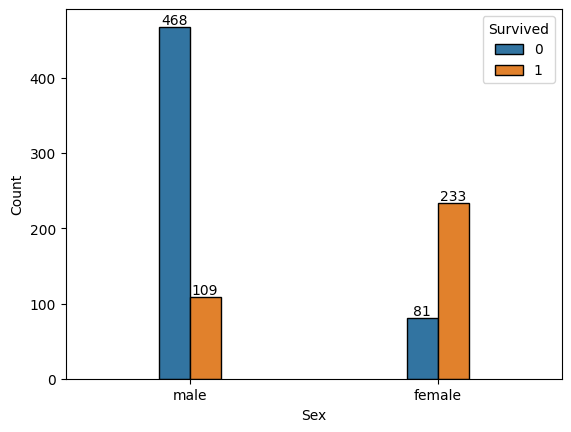

In [13]:
ax = sns.barplot(data=survived_per_sex, x='Sex', y='Count', hue='Survived', width=0.25, edgecolor='black')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

In [14]:
dead = train_df[train_df.Survived == 0].Pclass.value_counts().reset_index().rename(columns={'index': 'Pclass', 'Pclass': 'Count'})
dead['Survived'] = 0

survived = train_df[train_df.Survived == 1].Pclass.value_counts().reset_index().rename(columns={'index': 'Pclass', 'Pclass': 'Count'})
survived['Survived'] = 1

survived_per_pclass = pd.concat([dead, survived], axis=0)

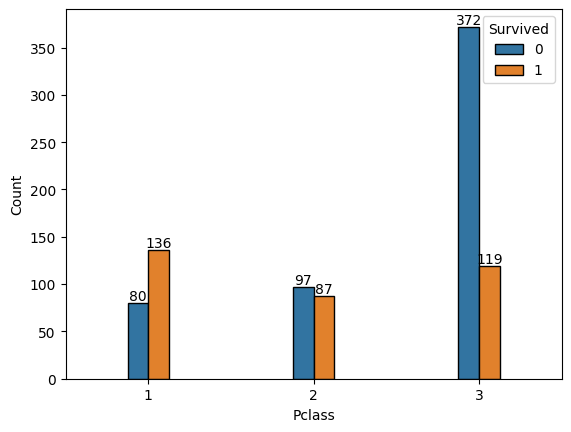

In [15]:
ax = sns.barplot(data=survived_per_pclass, x='Pclass', y='Count', hue='Survived', width=0.25, edgecolor='black')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

<Axes: xlabel='Age', ylabel='Fare'>

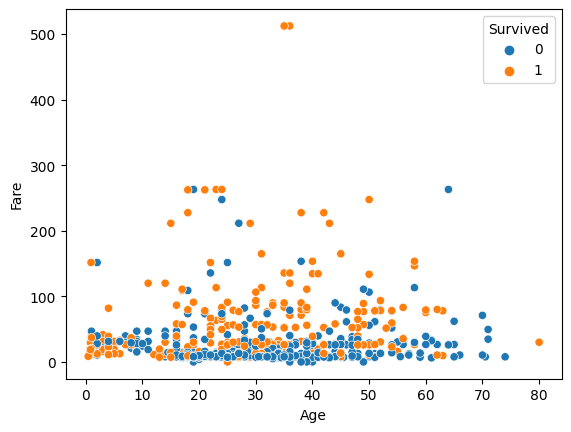

In [16]:
sns.scatterplot(data=train_df, x='Age', y='Fare', hue='Survived')

<Axes: xlabel='Age', ylabel='Count'>

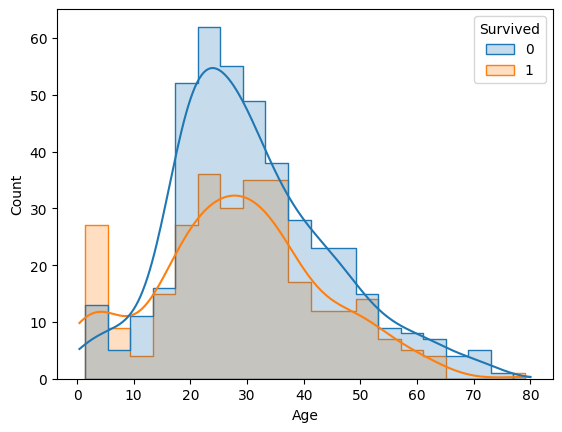

In [17]:
sns.histplot(data=train_df, x='Age', hue='Survived', multiple='layer', shrink=0.5, kde=True, bins=20, element='step')

<Axes: xlabel='Age', ylabel='Count'>

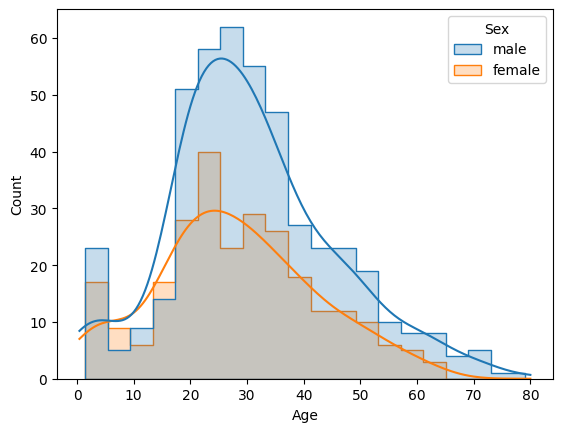

In [18]:
sns.histplot(data=train_df, x='Age', hue='Sex', multiple='layer', shrink=0.5, kde=True, bins=20, element='step')

<Axes: xlabel='Sex', ylabel='Age'>

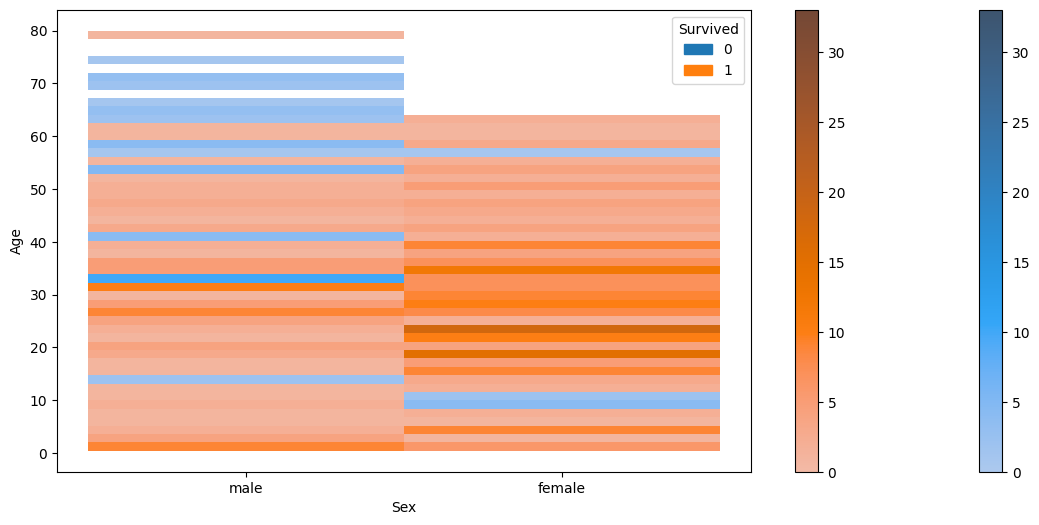

In [19]:
fig, ax = plt.subplots(figsize=(14,6))
sns.histplot(data=train_df, x='Sex', y='Age', hue='Survived', bins=50, cbar=True, ax=ax)

<Axes: xlabel='Sex', ylabel='Age'>

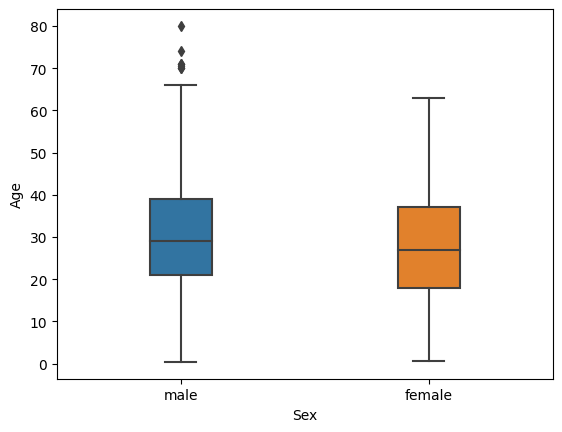

In [20]:
sns.boxplot(data=train_df, x='Sex', y='Age', width=0.25)

<Axes: xlabel='Survived', ylabel='Age'>

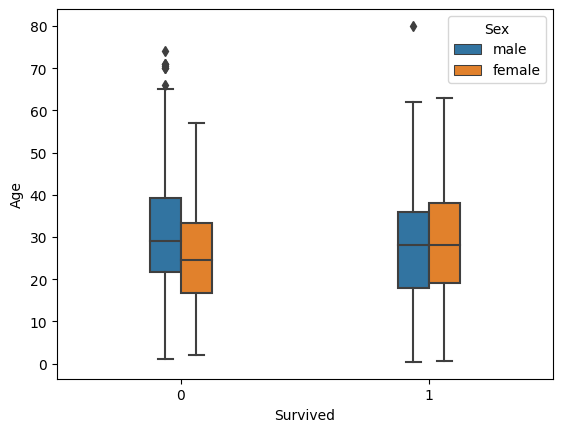

In [21]:
sns.boxplot(data=train_df, x='Survived', y='Age', hue='Sex', width=0.25)

<Axes: xlabel='Survived', ylabel='Fare'>

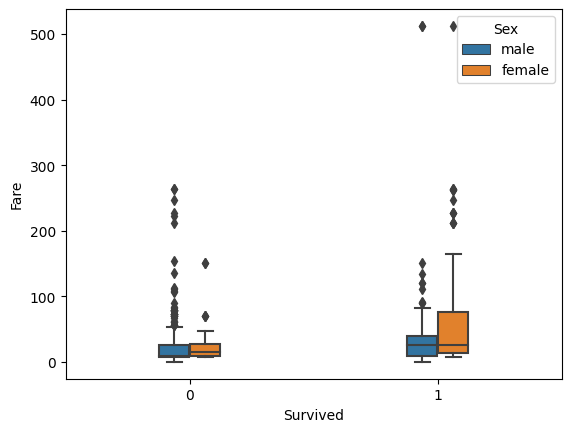

In [22]:
sns.boxplot(data=train_df, x='Survived', y='Fare', hue='Sex', width=0.25)

### Preprocessing

In [23]:
percent = train_df.isnull().mean()
percent

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [24]:
most_null_cols = percent[percent > 0.75].index
train_df = train_df.drop(columns=most_null_cols)
train_df.sample(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0,S


In [25]:
train_df = train_df.drop(columns=['PassengerId', 'Name','Ticket']) # useless features
#test_df = test_df.drop(columns=['PassengerId', 'Name','Cabin', 'Ticket'])

In [26]:
train_df.sample(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
701,1,1,male,35.0,0,0,26.2875,S


In [27]:
types = train_df.dtypes.reset_index()
types.columns = ['Feature', 'type']
types

,Feature,type
0,Survived,int64
1,Pclass,int64
2,Sex,object
3,Age,float64
4,SibSp,int64
5,Parch,int64
6,Fare,float64
7,Embarked,object


In [28]:
# Matriz de features X e vetor TARGET y
X_ = train_df.loc[:, train_df.columns != 'Survived']
y_ = train_df.Survived

In [29]:
CATEGORICAL_FEATURES = X_.select_dtypes(include='object').columns.tolist()
NUMERICAL_FEATURES = X_.select_dtypes(exclude='object').columns.tolist()

In [30]:
numerical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='mean')),
           ('scaler', MinMaxScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]
)

column_transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NUMERICAL_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ]
)

pipe = Pipeline(
    steps=[('transformer', column_transformer),
           ('estimator', DecisionTreeClassifier())
    ]
)

In [31]:
# Separando a base pré-processada em bases treino e teste
# seguindo uma proporção de 25% para a de teste
X_train, X_test, y_train, y_test = train_test_split(
X_, y_, test_size=0.25, random_state=42)

In [32]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('estimator', DecisionTreeClassifier())])

In [33]:
pipe.score(X_test, y_test)

0.7219730941704036

In [34]:
min_samples_leaf_range = [1, 5, 10, 15, 20, 25, 30]
min_samples_split_range = [2, 3, 4, 5, 6]
params = {'estimator__criterion': ['gini', 'entropy', 'log_loss'],
          'estimator__splitter': ['best', 'random'],
          'estimator__min_samples_leaf': min_samples_leaf_range,
          'estimator__min_samples_split': min_samples_split_range,
          'estimator__max_depth': [None, 3, 4, 5, 6],
          'estimator__max_leaf_nodes': [4, 6, 8, 10]}

In [35]:
tree_gscv = GridSearchCV(estimator=pipe, param_grid=params, verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 4200 candidates, totalling 21000 fits


In [36]:
tree_gscv

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Sex',
                                                                          'Embarked'])])),
                                       ('estimator',
                                        DecisionTreeClassifier())]),
             param_grid={'estimator__criterion': ['gini', 'entropy',
                                                  'log_loss'],
                         'estimator__max_depth': [None, 3, 4, 5, 6],
                         'estimator__max_leaf_nodes': [4, 6, 8, 10],
                         'estimator__min_samples_leaf': [1, 5, 10, 15, 20, 25,
                                                         30],
                         'estimator__min_samples_split': [2, 3, 4, 5, 6],
                         'estimator__splitter': ['best', 'random']},
             verbose=True)

In [37]:
tree_gscv.best_score_

0.8338345864661655

In [42]:
tree_gscv.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('estimator',
                 DecisionTreeClassifier(max_depth=6, max_leaf_nodes=10,
                                        min_samples_split=3,
                                        splitter='random'))])

In [38]:
y_hat = tree_gscv.predict(X_test)
precision_score(y_test, y_hat)

0.8382352941176471

In [39]:
recall_score(y_test, y_hat)

0.6404494382022472

In [40]:
accuracy_score(y_test, y_hat)

0.8071748878923767

In [41]:
confusion_matrix(y_test, y_hat)

array([[123,  11],
       [ 32,  57]], dtype=int64)